<h1 style='text-align:center;'> Classifying Forest Cover Type with a Deep Learning Model </h1>
<h2 style='text-align:center;'> A Codecademy Pro Portfolio Project </h2>
<br>
<br>
<h3> Part 1: Exploratory Data Analysis </h3>
<br>
Any good data science project starts with thorough exploratory data analysis. What do the data distributions look like? Which, if any, of the features in the data set seem to be associated with the feature you want to classify? 
This piece of code seeks to answer those questions as part of my exploratory data analysis for this project. I have separated it from my model building and evaluating codes to practice building modular code, and to begin disciplining myself to write chunks of code where the functions being defined and used have a clear, common purpose. If the reader isn't interested in the model building and/or evaluation that I did for the project, but is instead interested in my exploratory data analysis, they can simply look at this code and ignore the other code files. This makes it easier for readers to pick and choose what they are most interested in seeing.
<br>
<br>
This notebook is broken down into the following sections:
<ol>
    <li> <a href='#Section1'> Loading Packages and Setting Intial Random Number Seeds </a> </li>
    <li> <a href='#Section2'> Loading and Examining the Data </a> </li>
    <li> <a href='#Section3'> Defining Functions </a> </li>
    <li> <a href='#Section4'> Exploratory Data Analysis </a> </li>
    <ol type = 'A'>
    <li> <a href='#Section4A'> Forest Cover Type Classes </a></li>
    <li> <a href='#Section4B'> Elevation </a></li>
    <li> <a href='#Section4C'> Aspect </a></li>
    <li> <a href='#Section4D'> Slope </a></li>
    <li> <a href='#Section4E'> Horizontal Distance to Hydrology </a></li>
    <li> <a href='#Section4F'> Vertical Distance to Hydrology  </a></li>
    <li> <a href='#Section4G'> Horizontal Distance to Roadways </a></li>
    <li> <a href='#Section4H'> Hill Shade at 9AM </a></li>
    <li> <a href='#Section4I'> Hill Shade at 12PM </a></li>
    <li> <a href='#Section4J'> Hill Shade at 3PM </a></li>
    <li> <a href='#Section4K'> Horizontal Distance to Fire Points </a></li>
    <li> <a href='#Section4L'> Wilderness Area </a></li>
    <li> <a href='#Section4M'> Soil Type </a></li>
    </ol>
    <li> <a href='#Section5'> Conclusions </a> </li>
</ol>


***
<a id="Section1"></a> 

<h4> Section 1: Loading Packages and Setting Intial Random Number Seeds </h4>

In [1]:
# Import analysis packages:
import pandas as pd
import numpy as np

# Import the random package (to ensure that random numbers have a set initial seed):
import random

# Import plotting packages:
from matplotlib import pyplot as plt
import seaborn as sns 

# Import hypothesis-testing methods:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
from pingouin import welch_anova, pairwise_gameshowell

In [2]:
#
#

# The below is necessary for starting core Python generated random numbers in a well-defined state.
random.seed(11)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(11)

***
<a id="Section2"></a> 

<h4> Section 2: Loading and Examining the Data </h4>

Obviously, in order to work with the data it must be read in. I do so below.

In [3]:
forest_cover_data = pd.read_csv('cover_data.csv')

I usually like to print out a DataFrame's .info() once I have the data read in, but I thought that this time it might be useful to see what some of the values looked like so I decided to print out .head(). My first call to .head() was .head(10), but given the sheer number of columns in this DataFrame that were printed to screen was very hard to read and interpret. So I dialed it back to .head(2).

In [4]:
print(forest_cover_data.head(2))

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   

   Soil_Typ

I printed out the forest_cover_data.info() (that command has since been moved a couple of cells down) and determined that there were no null/NaN values in the data set. I appreciated this from the Codecademy developers, as any day that I don't need to decide what to do about NaNs is a good day. I was a little worried about the possibility of duplicate rows, so I decided to drop any which might exist:

In [4]:
forest_cover_data = forest_cover_data.drop_duplicates()

... As it turns out, there were not actually any duplicate rows in the DataFrame. Better to be safe than sorry.

I will need to do one calculation with the data in order to make them more interpretable. The feature 'Aspect,' as <a href = 'https://en.wikipedia.org/wiki/Aspect_(geography)'>Wikipedia</a> tells me, is the compass direction that a terrain surface faces. It appears to be being measured in degrees in this data set, from 0 to 360, which indicates to me that aspect must be similar to what I as an astrophysicist know as azimuth. Azimuth, in turn, I know to be measured in terms of degrees clockwise from true north: thus, true north has an azimuth of 0 degrees, due east has an azimuth of 90 degrees, due south has an azimuth of 180 degrees, and due west has an azimuth of 270 degrees. (<a href='https://www.heavens-above.com/glossary.aspx?term=azimuth'>Heavens-Above</a> has a lovely explanation of azimuth, including a very illustrative image.) So, an aspect of 359 degrees is actually very close to 0 degrees, i.e. true north, which isn't immediately obvious from looking at the "raw" aspect histogram. To make the relationship between very large aspects and very small aspects more obvious, I will simply take aspect-360 for any aspect larger than 180 degrees. This in turn makes angles near due south (i.e. aspect 180 degrees) harder to interpret, but I suspect there are more northward-facing surfaces than southward-facing surfaces. I now carry out this calculation:

In [5]:
forest_cover_data["AspectMod"] = forest_cover_data['Aspect'].apply(lambda x: (x-360) if x > 180 else x)

The only thing I wanted to do was to add a column to the DataFrame which translated from numerical class to class in words as provided by Codecademy. Lacking any information to the contrary, I assume that the order they provided the classes in words is the same as the numerical classes in the DataFrame; that is to say, since 'Spruce/Fir' was listed first, I assume that it is class 1, that 'Lodgepole Pine' is class 2, and so forth. .map() takes care of this very quickly.

In [6]:
forest_cover_data["Cover_Type"] = forest_cover_data['class'].map({ 1:'Spruce/Fir',  2:'Lodgepole Pine',  \
                                                                   3:'Ponderosa Pine',  4:'Cottonwood/Willow',
                                                                   5:'Aspen', 6:'Douglas-fir', 7:'Krummholz'})

Lastly, I print out the call to forest_cover_data.info() that I referenced above. It appears as though there were a lot of different soil types, as the one-hot encoding for that nominal categorical variable produced a lot of columns. Wilderness area was also one-hot encoded, but there were only 4 of those. I do not need to convert any objects to ints or floats, and save for the 'class' column all of the columns are reasonably named. Referencing the 'class' column by forest_cover_data.class obviously caused some issues, but there are other ways to reference columns of DataFrames so I will utilize those instead.

In [7]:
print(forest_cover_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581012 entries, 0 to 581011
Data columns (total 57 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           581012 non-null  int64 
 1   Aspect                              581012 non-null  int64 
 2   Slope                               581012 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64 
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64 
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64 
 6   Hillshade_9am                       581012 non-null  int64 
 7   Hillshade_Noon                      581012 non-null  int64 
 8   Hillshade_3pm                       581012 non-null  int64 
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64 
 10  Wilderness_Area1                    581012 non-null  int64 
 11  Wilderness_Area2                    581

The data is now ready for exploratory data analysis.

***
<a id="Section3"></a> 

<h4> Section 3: Defining Functions </h4>

The first thing I wanted to do is take a look at some of the summary statistics of the data, <b>broken down by cover type classification</b>. While the Pandas command .describe() would have been easy to call, it would not have split the data up by cover type classification; so, I wrote my own function to do summary statistics on a continuous quantitative column in the forest_cover_data DataFrame, grouping the data by class. It is highly unlikely that all of the data distributions will be Gaussian distributed or anything remotely like it, so I chose not to calculate variances or standard deviations; instead, I found the quartiles of the data and from there calculated the IQR. In the output DataFrame, the quartiles are provided as an array in the following format: [Q1 Q2 Q3]. The data's quartiles and IQR, along with its minimum and maximum values, should give a general sense of its spread. The average and median values of the data, in turn, will give some sense of the "typical" value. <br>
I would like to credit <a href="https://kiwidamien.github.io/stylish-pandas.html">Damien martin</a> and his guide for formatting Pandas DataFrames for helping me get calculated values rounded and displayed as I wanted.

In [8]:
def get_summary_stats(column_name):
    
    # pluck off the data in column_name which belongs to each of the cover type classes, and store those
    # data in their own Series:
    temp_class1 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Spruce/Fir']
    temp_class2 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Lodgepole Pine']
    temp_class3 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Ponderosa Pine']
    temp_class4 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Cottonwood/Willow']
    temp_class5 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Aspen']
    temp_class6 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Douglas-fir']
    temp_class7 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Krummholz']
    
    # get the data's quartiles:
    quarts_class1 = np.fix(np.quantile(temp_class1,[0.25,0.5,0.75]))
    quarts_class2 = np.fix(np.quantile(temp_class2,[0.25,0.5,0.75]))
    quarts_class3 = np.fix(np.quantile(temp_class3,[0.25,0.5,0.75]))
    quarts_class4 = np.fix(np.quantile(temp_class4,[0.25,0.5,0.75]))
    quarts_class5 = np.fix(np.quantile(temp_class5,[0.25,0.5,0.75]))
    quarts_class6 = np.fix(np.quantile(temp_class6,[0.25,0.5,0.75]))
    quarts_class7 = np.fix(np.quantile(temp_class7,[0.25,0.5,0.75]))
    
    # gather up a dictionary for later conversion to a DataFrame:
    tempdict = {'Cover_Type':['Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen',\
                              'Douglas-fir','Krummholz'],\
                # calculate the average value of column_name for each class, and round to the nearest whole number:
                'Avg':['{:.0f}'.format(temp_class1.mean()),'{:.0f}'.format(temp_class2.mean()),\
                       '{:.0f}'.format(temp_class3.mean()),'{:.0f}'.format(temp_class4.mean()),\
                       '{:.0f}'.format(temp_class5.mean()),'{:.0f}'.format(temp_class6.mean()),\
                       '{:.0f}'.format(temp_class7.mean())],\
                # calculate the median value of column_name for each class, and round to the nearest whole number:
                'Median':['{:.0f}'.format(temp_class1.median()),'{:.0f}'.format(temp_class2.median()),\
                          '{:.0f}'.format(temp_class3.median()),'{:.0f}'.format(temp_class4.median()),\
                          '{:.0f}'.format(temp_class5.median()),'{:.0f}'.format(temp_class6.median()),\
                          '{:.0f}'.format(temp_class7.median())],\
                # find the minimum value of column_name for each class:
                'Min':[min(temp_class1),min(temp_class2),min(temp_class3),min(temp_class4),\
                       min(temp_class5),min(temp_class6),min(temp_class7)],\
                # find the maximum value of column_name for each class:
                'Max':[max(temp_class1),max(temp_class2),max(temp_class3),max(temp_class4),\
                       max(temp_class5),max(temp_class6),max(temp_class7)],\
                # gather up the quartiles calculated above:
                'Quartiles':[quarts_class1,quarts_class2,quarts_class3,quarts_class4,\
                             quarts_class5,quarts_class6,quarts_class7],\
                # calculate the interquartile range (IQR) for each class:
               'IQR':[quarts_class1[2]-quarts_class1[0],quarts_class2[2]-quarts_class2[0],\
                      quarts_class3[2]-quarts_class3[0],quarts_class4[2]-quarts_class4[0],\
                      quarts_class5[2]-quarts_class5[0],quarts_class6[2]-quarts_class6[0],\
                      quarts_class7[2]-quarts_class7[0]]}
    
    # convert from a dictionary to a DataFrame:
    df_to_return = pd.DataFrame(tempdict)

    # return the DataFrame:
    return df_to_return

The next thing I wanted to do was take a look at the distributions of data in each continuous, quantitative column. As a physicist, my default is to plot a histogram of data in quantitative columns; this allows me to see what, if any, kind of distribution the data seem to follow. It also allows me to see if the data is unimodal or multimodal, how quickly counts grow or drop off, if there are any plateaus, etc. I would like to make plots not only for the continuous quantitative column as a whole, but for its data broken down by cover type class. Hard experience has taught me that overlapping histograms don't offer much insight into how data distributions differ in shape if the distributions have a lot of overlap and there are more than, say, three of them. This is surely to be the case for some quantitative columns, but perhaps not for others. To still give some insight into the overall shape of the distributions of quantitative columns split by cover type, I choose to plot violin plots of the data. Violin plots plot the KDE of each distribution (basically, smoothed versions of the histograms) in addition to median and interquartile data information; the ability to see trends in the distribution make them, for this purpose, superior in my mind to box plots (which allow for easy comparisons of the interquartile ranges of the distributions, as well as outliers, but offer little insight into the details of the distributions themselves). <br>
In the function defined below, I can choose which of three plots for each continuous, quantitative column I want to make: a histogram of all the column data, a violin plot of the data split by cover type class, or histograms of the data split by cover type class. The third plot is actually quite informative for a handful of columns, but for others it is pretty much useless. I will call the function for every quantitative column, but I will not always run it; I include the function call so that the reader can run the line of code for themselves to decide whether or not the plot is informative.

In [9]:
def plot_a_distribution(column_name, plottype, nbins = 40, numofbins=40):
    
    # define a "context" for the plots, which allow me to control how tickmark fonts are scaled and the width of lines:
    sns.set_context("notebook", font_scale=0.8, rc={"lines.linewidth": 1.5})
    
    ########################################################
    # PLOT #1: Histogram of all of the data in column_name:#
    ########################################################
    if plottype == 'all_hist':
        # set a size for the figure:
        plt.figure(figsize=(9,5))
        # I noticed that my initial histogram of the slope distribution had some gaps in it. So, make sure the discrete
        # keyword is set for this plot, in addition to the KDE keyword:
        if column_name == 'Slope':
            sns.histplot(forest_cover_data[column_name], bins = nbins, kde = True, discrete = True)
        # otherwise, plot the histogram without the discrete keyword being turned on. Do turn on the KDE keyword: 
        else:
            sns.histplot(forest_cover_data[column_name], bins = nbins, kde = True)
        # Aspect and slope are measured in degrees. Make sure the horizontal axes of these histograms 
        # are properly labeled with the correct units:
        if (column_name == 'Aspect') or (column_name == 'AspectMod') or (column_name == 'Slope'):
            plt.xlabel(column_name + ' [degrees]', fontsize=13)
        # I confess to having no idea what units hill shade is measured in. So, I label the horizontal axes of these 
        # histograms but do not include units:
        elif (column_name == 'Hillshade_9am') or (column_name == 'Hillshade_Noon') or (column_name == 'Hillshade_3pm'):
            plt.xlabel(column_name, fontsize=13)
        # All other quantitative columns seem to be distance measurements; hence, the proper labeling for the 
        # horizontal axes of these histograms includes units of meters [m] in addition to the variable name:
        else:
            plt.xlabel(column_name + ' [m]', fontsize=13)
        # Give the vertical axis an informative label:
        plt.ylabel('Counts per Bin', fontsize=13)
        # Give the plot an informative title:
        plt.title(column_name + ' Distribution', fontsize=18)


    ###########################################################################
    # PLOT #2: Violin plot the data in column_name, split by cover type class:#
    ###########################################################################
    elif plottype == 'violin':
        # set a size for the figure:
        plt.figure(figsize=(16,10))
        # plot a violin plot of the data in column_name, split by cover type class:
        sns.violinplot(data = forest_cover_data, x = 'Cover_Type', y = column_name, \
                       order = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', \
                                'Aspen', 'Douglas-fir','Krummholz'], scale = 'area', inner = 'box')
        # Make sure the horizontal axis has an informative label:
        plt.xlabel('Cover Type', fontsize=13)    
        # Aspect and slope are measured in degrees. Make sure the vertical axes of these violin plots 
        # are properly labeled with the correct units:
        if (column_name == 'Aspect') or (column_name == 'AspectMod') or (column_name == 'Slope'):
            plt.ylabel(column_name + ' [degrees]', fontsize=13)
        # I still have no idea what units hill shade is measured in. So, I label the vertical axes of these 
        # violin plots but do not include units:
        elif (column_name == 'Hillshade_9am') or (column_name == 'Hillshade_Noon') or (column_name == 'Hillshade_3pm'):
            plt.ylabel(column_name, fontsize=13)
        # All other quantitative columns seem to be distance measurements; hence, the proper labeling for the vertical
        # axes of these violin plots includes units of meters [m] in addition to the variable name:
        else:
            plt.ylabel(column_name + ' [m]', fontsize=13)
        # Give the plot an informative title:
        plt.title('Violin Plot of the ' + column_name + ' Distribution, Split by Cover Type', fontsize=18)

        
    ##########################################################################
    # PLOT #3: Histograms the data in column_name, split by cover type class:#
    ##########################################################################
    elif plottype == 'split_hist':
        # To make my life easier, pluck off the data in column_name which belongs to each of the cover type classes, 
        # and store those data in their own Series:
        temp_class1 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Spruce/Fir']
        temp_class2 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Lodgepole Pine']
        temp_class3 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Ponderosa Pine']
        temp_class4 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Cottonwood/Willow']
        temp_class5 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Aspen']
        temp_class6 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Douglas-fir']
        temp_class7 = forest_cover_data[column_name][forest_cover_data['Cover_Type'] == 'Krummholz']
   
        # set a size for the figure:
        plt.figure(figsize=(16,5))
        # I noticed that my initial histograms of the slope distributions had some gaps in them. So, make sure the 
        # discrete keyword is set for these histogram plots, in addition to the KDE keyword. Also, plot density 
        # rather than counts, as some classes have many more records than other classes:
        if column_name == 'Slope':
            sns.histplot(temp_class1, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'rosybrown', \
                         discrete = True, common_norm = False)
            sns.histplot(temp_class2, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'olivedrab', \
                         discrete = True, common_norm = False)
            sns.histplot(temp_class3, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'teal', \
                         discrete = True, common_norm = False)
            sns.histplot(temp_class4, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'silver', \
                         discrete = True, common_norm = False)
            sns.histplot(temp_class5, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'purple', \
                         discrete = True, common_norm = False)
            sns.histplot(temp_class6, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'maroon', \
                         discrete = True, common_norm = False)
            sns.histplot(temp_class7, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'darkblue', \
                         discrete = True, common_norm = False)
        # otherwise, plot the histograms without the discrete keyword being turned on. Do turn on the KDE keyword. And
        # again plot density rather than counts: 
        else:
            sns.histplot(temp_class1, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'rosybrown', \
                     common_norm = False)
            sns.histplot(temp_class2, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'olivedrab', \
                     common_norm = False)
            sns.histplot(temp_class3, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'teal', \
                     common_norm = False)
            # The distributions of horizontal_distance_to_hydrology and vertical_distance_to_hydrology, for the
            # Cottonwood/Willow class, showed a sharp spike at 0 followed by a very steep fall-off. The below is my
            # attempt to come up with a binning that will "spread out" the spike a bit. It did not work as well as I'd
            # hoped, but is better than the default of 40 bins.
            if column_name == 'Horizontal_Distance_To_Hydrology':
                sns.histplot(temp_class4, bins = 25, stat = 'density', kde = True, alpha = 0.50, color = 'silver', \
                             common_norm = False)
            elif column_name == 'Vertical_Distance_To_Hydrology':
                sns.histplot(temp_class4, bins = 15, stat = 'density', kde = True, alpha = 0.50, color = 'silver', \
                             common_norm = False)
            else:
                sns.histplot(temp_class4, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'silver', \
                             common_norm = False)
            sns.histplot(temp_class5, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'purple', \
                         common_norm = False)
            sns.histplot(temp_class6, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'maroon', \
                         common_norm = False)
            sns.histplot(temp_class7, bins = numofbins, stat = 'density', kde = True, alpha = 0.50, color = 'darkblue', \
                         common_norm = False)
        # Give the plot a legend, so that one knows which histogram corresponds to which cover type class:
        plt.legend(['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir',\
                    'Krummholz'], fontsize=11)
        # Aspect and slope are measured in degrees. Make sure the horizontal axes of these histograms 
        # are properly labeled with the correct units:
        if (column_name == 'Aspect') or (column_name == 'AspectMod') or (column_name == 'Slope'):
            plt.xlabel(column_name + ' [degrees]', fontsize=13)
        # I still have no idea what units hill shade is measured in. So, I label the horizontal axes of these 
        # histograms but do not include units:
        elif (column_name == 'Hillshade_9am') or (column_name == 'Hillshade_Noon') or (column_name == 'Hillshade_3pm'):
            plt.xlabel(column_name, fontsize=13)
        # All other quantitative columns seem to be distance measurements; hence, the proper labeling for the 
        # horizontal axes of these histograms includes units of meters [m] in addition to the variable name:
        else:
            plt.xlabel(column_name + ' [m]', fontsize=13)
        # Give the vertical axis an informative label:
        plt.ylabel('Density', fontsize=13)
        # Give the plot an informative title:
        plt.title(column_name + ' Distribution, Split by Cover Type', fontsize=18)

Finally, I wanted a quantitative way to determine if there was an association between each continuous, quantitative variable and forest cover classification. Codecademy advocates looking at the overlap between histograms to determine association, but that is hard to quantify. How much overlap "counts" as an association? How separate must histograms be in order to justify including the quantitative feature in a deep learning classification model of forest cover class? According to <a href="https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365">this Medium post</a> by user Outside Two Standard Deviations, determining the correlation (if any) between a continuous variable and a categorical variable is tricky, but can at least be broken down into three big picture methods. At first, I chose to focus on performing a Kruskal-Wallis H-test on the data, as it probes how much of the variance in continuous, quantitative data can be explained using a categorical feature. The advantage with the Kruskal-Wallis test is that it does not assume the quantitative data are normally distributed, as ANOVA does: that is to say, the Kruskal-Wallis test is a non-parametric test. However, it <i>does</i> assume that the data have approximately the same shape/spread, which a quick glance at any of the violin plots I made for the quantitative columns reveals is not necessarily the case. <a href="http://www.biostathandbook.com/kruskalwallis.html">This page</a> of the Handbook of Biological Statistics by John H. McDonald recommended in its place a Welch's ANOVA analysis, which I chose to do. The post-hoc test associated with Welch's ANOVA, should a p-value below the <i>a priori</i> chosen significance threshold be found, is the Games-Howell post-hoc test (which also has the advantage of being a non-parametric test). It is this combination of correlation analysis that I used to determine if data in a quantitative column and forest cover type seemed to be correlated, and if so which specific cover types showed a significant difference between them.<br>
My <i>a priori</i> chosen significance threshold was 0.001, which posed no problem for the Welch's ANOVA analysis I performed, but wasn't a great choice for the follow-up Games-Howell post-hoc test. I was disappointed to find that neither test had an implementation in SciPy, but they did in Pingoin. To the best of my ability to tell, the developer(s) of the Pingpoin code which implements a Games-Howell post-hoc test chose to return a value of 0.001 if the actual p-value fell below 0.001. (Perhaps they could not conceive of anyone choosing a significance threshold below, say, 0.01 or 0.005; a value of 0.001 is clearly safely below either threshold.) So, I treat a value of 0.001 which results from the Games-Howell post-hoc tests that I run as an upper limit, and actually indicative that the difference between two distributions which have this p-value as significant, despite my <i>a priori</i>-chosen value.

In [10]:
def test_for_association_welch(column_name):
    
    # perform a Welch's ANOVA analysis on the column_name and cover type class data using the Pingoin implementation:
    anal_of_var = welch_anova(data=forest_cover_data, dv=column_name, between='Cover_Type')
    
    # Pingoin statistical test functions return a DataFrame which contains a whole host of information. I am most
    # interested in the p-value associated with the test, so I pluck it out of the DataFrame:
    pval_df = anal_of_var['p-unc']
    pval = pval_df.iloc[0]
    
    # Print out the test's p-value:
    print('Welch ANOVA p-value for ' + column_name + '/class association: '+ str(pval))
    
    # The first run through of all quantitative columns using this function revealed that all p-values were
    # below my chosen threshhold. Therefore, I chose to add the below Games-Howell test. I don't plan on actually 
    # using its results for anything, but it is nice to see precisely which cover type differ from each other.
    
    # perform a Games-Howell post-hoc test on the column_name and cover type class data, and round the results to
    # 3 digits:
    gameshowelltestresult = pairwise_gameshowell(data=forest_cover_data, dv=column_name, between='Cover_Type').round(3)
    # Of all the columns in the DataFrame returned by pairwise_gameshowell, the columns for the names of the cover
    # type classes, their mean values, the T-value, and the p-value seemed the most important to keep and print to
    # screen. Gather these columns into a new DataFrame:
    ghtestresult = gameshowelltestresult[['A','B','mean(A)','mean(B)','T','pval']]
    # Print an empty string, to make a buffer between the previous output and the following one:
    print('')
    # Print out the ghtestresult DataFrame:
    print("Games-Howell pairwise test for multiple comparisons of means:")
    print(ghtestresult)

***
<a id="Section4"></a> 

<h4> Section 4: Exploratory Data Analysis </h4>

***
<a id="Section4A"></a> 

<h5> A: Forest Cover Type Classes </h5>

One of the first things I wanted to know about the data was how many records of each forest cover class type there were. This is important to know when building a machine learning classification model because it impacts how I will split the data between training, validation, and test subsets. If the classes are imbalanced, I will need to take that into account when performing the split.

In [11]:
print(forest_cover_data['Cover_Type'].value_counts())

Lodgepole Pine       283301
Spruce/Fir           211840
Ponderosa Pine        35754
Krummholz             20510
Douglas-fir           17367
Aspen                  9493
Cottonwood/Willow      2747
Name: Cover_Type, dtype: int64


It is indeed the case that the classes are imbalanced: there are many more Lodgepole Pines and Spruce/Firs than there are Aspens or Cottonwood/Willows. I will need to take this into account when splitting the data into training, validation, and test subsets for my deep learning model building; I will also need to make sure that my histogram plots for data split by forest cover type plot density instead of counts, so that the scales of the histograms are not dominated by the most populous classes.

***
<a id="Section4B"></a> 

<h5> B: Elevation </h5>

In [48]:
elev_stats = get_summary_stats('Elevation')
print(elev_stats)

          Cover_Type   Avg Median   Min   Max                 Quartiles    IQR
0         Spruce/Fir  3129   3146  2466  3686  [3033.0, 3146.0, 3235.0]  202.0
1     Lodgepole Pine  2921   2935  2142  3433  [2794.0, 2935.0, 3042.0]  248.0
2     Ponderosa Pine  2395   2404  1859  2899  [2260.0, 2404.0, 2549.0]  289.0
3  Cottonwood/Willow  2224   2231  1988  2526  [2142.0, 2231.0, 2304.0]  162.0
4              Aspen  2787   2796  2482  3011  [2732.0, 2796.0, 2857.0]  125.0
5        Douglas-fir  2419   2428  1863  2900  [2320.0, 2428.0, 2544.0]  224.0
6          Krummholz  3362   3363  2868  3858  [3299.0, 3363.0, 3409.0]  110.0


There seem to be two broad groups of trees here: one which "likes" higher elevations (Spruce/Fir, Lodgepole Pine, Aspen, and Krummholz) and one which "likes" lower elevations (Ponderosa Pine, Cottonwood/Willow, and Douglas-fir).  My justiifcation for including Aspens in the "likes high elevation" group is that the upper part of its IQR intersects the lower part of the IQR of Lodgepole Pines, and is clearly separated from the uppermost limit of the IQR of the other 3 species. While the average elevation for Aspen trees is only about 2,800 m, that's not too far from the average elevation of Lodgepole Pines, and much higher than the average elevations of Ponderosa Pines, Cottonwood/Willows, and Douglas-firs. 
<br>
There does not appear to be a relationship between IQR and tree type: trees which like lower elevations have both the highest and the lowest IQR in the data set, and there is a 100 m difference between the highest IQR and the lowest IQR among trees which like higher elevations. 
<br>
On the whole, even before running my statistical analysis, there seems to be evidence that elevation and forest cover type are correlated; that is to say, knowing something about cover type tells you something about elevation.

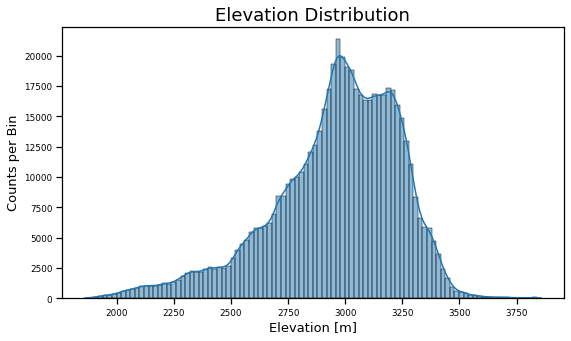

In [64]:
plot_a_distribution('Elevation', 'all_hist', nbins=100)

This distribution is very interesting. It is clearly multimodal, with peaks at about 2,800 m andd 3,250 m or so. It's quite wide, and skews left a little bit (i.e., there is a longer tail toward lower elevations than there is at higher elevations). 

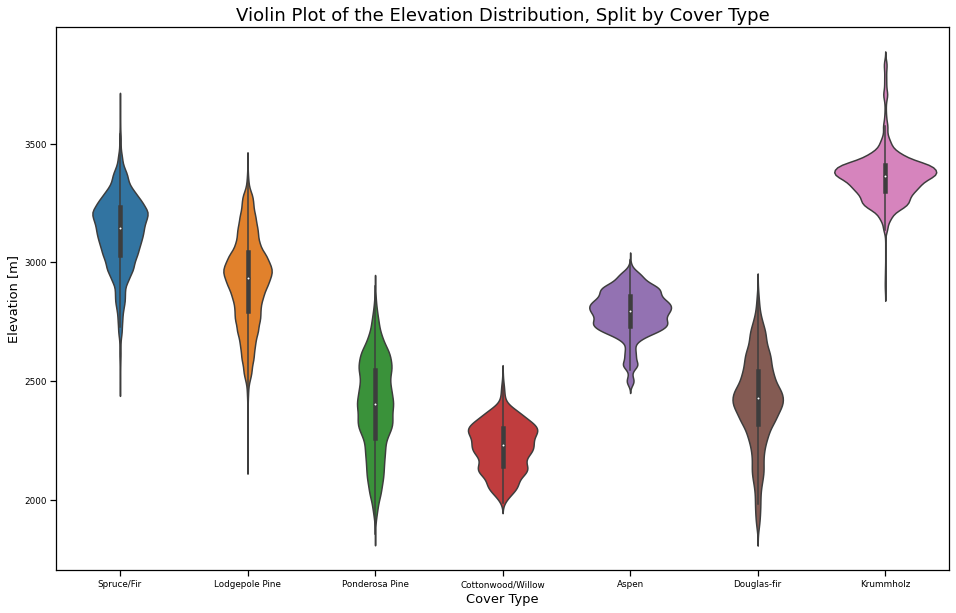

In [79]:
plot_a_distribution('Elevation', 'violin')

This violin plot is quite informative. One can immediately see that the Cottonwood/Willow, Aspen, and Krummholz distributions are quite narrow, whereas the Lodgepole Pine, Ponderosa Pine, and Douglas-fir distributions are quite wide. There is zero overlap between the Krummholz and Cottonwood/Willow distributions, whereas the elevation distribution of Aspen trees has some overlap with every other elevation distribution. One can also identify three "tiers:" a low elevation tier (Ponderosa Pine, Cottonwood/Willow, Douglas-fir), a mid-elevation tier (Aspen, Lodgepole Pine), and a high elevation tier (Spruce/Fir, Krummholz). <br>
This tells me a couple of things. First of all, just based on elevation alone it will be pretty easy to differentiate between Cottonwood/Willow, Aspen, and Krummholz trees. Secondly, it will be harder to differentiate Ponderosa Pine and Douglas-fir trees based on just elevation data, and simiarly with Spruce/Firs and Lodgepole Pines. But given the different shapes, spreads, and centers of the 7 distributions, it is clear that elevation and forest cover type are associated.

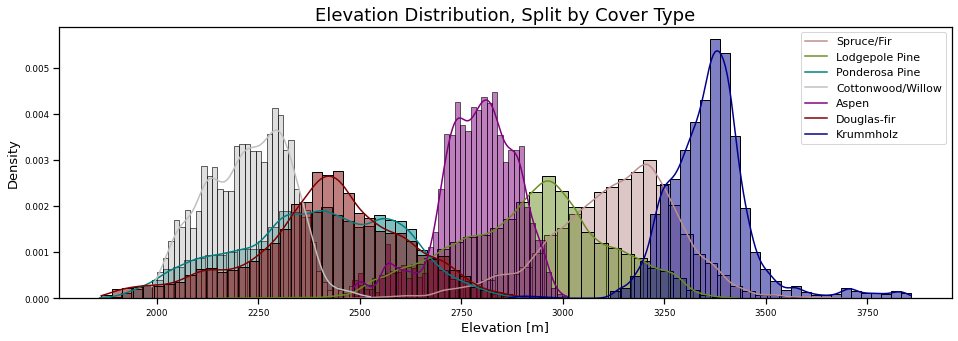

In [66]:
plot_a_distribution('Elevation', 'split_hist')

This particular feature was the one for which plotting the histograms of elevation split by cover type yielded clear insight into the differences between classes. One thing is readily apparent: the shapes of the distributions are by no means the same. Indeed, while the distribution of Aspen elevations is almost Gaussian, the shapes of the Spruce/Fir, Douglas-fir, Lodgepole Pine, and Ponderosa Pine distributions are clearly not. There is clear separation between trees which like low elevation and trees which like high elevation, with Aspen trees being somewhat in the middle. <br>
While the violin plot of elevation split by cover type and the elevation histograms of each individual cover type provide strong qualitative evidence that elevation and cover type are correlated, it is good to run a statistical analysis to ensure that this is in fact the case. I do so below, first by running a Welch ANOVA analysis on the elevation data split by cover type, and a follow-up Games-Howell post-hoc test to see which (if any) distributions distrubtions differ from each other. One can see from the plots and calculated IQRs that the shapes and spreads of the distributions are by no means uniform, so the Welch ANOVA test was a good choice. <br>
I must choose a threshhold value below which I will consider a calculated p-value to indicate a significant difference: I will be quite conservative and choose a value of 0.001. This gives a pretty low chance of a false positive (i.e., that there really isn't a significant difference between the distributions even though the p-value falls below my threshhold), and given that I have over 580,000 data points I think I can justify choosing so low a threshhold value. 

In [14]:
test_for_association_welch('Elevation')

Welch ANOVA p-value for Elevation/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B   mean(A)   mean(B)        T   pval
0               Aspen  Cottonwood/Willow  2787.418  2223.940  256.941  0.001
1               Aspen        Douglas-fir  2787.418  2419.182  211.388  0.001
2               Aspen          Krummholz  2787.418  3361.929 -462.923  0.001
3               Aspen     Lodgepole Pine  2787.418  2920.936 -126.973  0.001
4               Aspen     Ponderosa Pine  2787.418  2394.510  273.396  0.001
5               Aspen         Spruce/Fir  2787.418  3128.645 -325.284  0.001
6   Cottonwood/Willow        Douglas-fir  2223.940  2419.182  -80.529  0.001
7   Cottonwood/Willow          Krummholz  2223.940  3361.929 -543.517  0.001
8   Cottonwood/Willow     Lodgepole Pine  2223.940  2920.936 -350.726  0.001
9   Cottonwood/Willow     Ponderosa Pine  2223.940  2394.510  -76.985  0.001
10  Cottonwood/Willow         Spr

Sure enough, the Welch ANOVA test indicated a significant difference between at least one distribution and one other distribution. (The actual p-value is almost certainly non-zero, but instead likely falls below the lowest value that the test is programmed to return.) The post-hoc Games-Howell pairwise test further indicates that every distribution is significantly different from every other distribution (recall my discussion above about the p-value of 0.001 and the coding of the Games-Howell test). <br>
Thus, as a result of all this analysis, I feel confident in including elevation among the features of my deep learning model of forest cover type: there is a clear association between elevation and cover type.

***
<a id="Section4C"></a> 

<h5> C: Aspect</h5>

In Section 2, I explained that using the feature 'Aspect' as reported in the data set without any modification could be misleading. This is due to the nature of how aspect is measured: namely, clockwise from due North, with values ranging from 0 to 360. Thus, an aspect of 359 degrees is very close to due north (aspect zero degrees); just looking at the raw numbers, one could be mislead into thinking that an aspect of 359 is very far from due north. Thus, in a sense, I decided to measure aspect by saying that angles measured clockwise from due north to due south are measured positive, and angles from due south to due north are measured negative (-179 degrees corresponds to a direction just west of south, and -1 degree corresponds to a direction just west of north). As I mentioned in Section 2, this transformation isn't perfect: it basically switches the "fold-over" problem from occuring at due north to occuring at due south. However, my intuition is that few trees will "want" to grow on south-facing surfaces, so fewer records should be impacted now than before the transformation. 

Let me illustrate the issue. I will find the summary statistics of the 'Aspect' column first: 

In [49]:
aspect_stats = get_summary_stats('Aspect')
print(aspect_stats)

          Cover_Type  Avg Median  Min  Max             Quartiles    IQR
0         Spruce/Fir  156    122    0  360  [52.0, 122.0, 278.0]  226.0
1     Lodgepole Pine  152    127    0  360  [60.0, 127.0, 241.0]  181.0
2     Ponderosa Pine  176    160    0  360  [90.0, 160.0, 284.0]  194.0
3  Cottonwood/Willow  137    119    0  359  [83.0, 119.0, 159.0]   76.0
4              Aspen  139    111    0  359  [71.0, 111.0, 191.0]  120.0
5        Douglas-fir  181    173    0  360  [43.0, 173.0, 319.0]  276.0
6          Krummholz  153    123    0  360  [66.0, 123.0, 240.0]  174.0


The average aspect, as calcualted on the 'raw' aspect column, seems to indicate that the average tree, regardless of species/type, "likes" to grow on south-east facing surfaces. Even the median values found above doesn't do what I'd expect: for each distribution, the median is not too far from the average, and smaller than it, at values just a bit south of due east. Further, the IRQs are all very large, for the most part, and look to be about 180 degrees or so. There are even values above 200 degrees! This doesn't seem right to me, and I suspect that fact that the peak in values was split at 0 degrees is contributing to the averages and medians I am calculating. Indeed, let's look at the raw 'Aspect' distribution to see what it looks like:

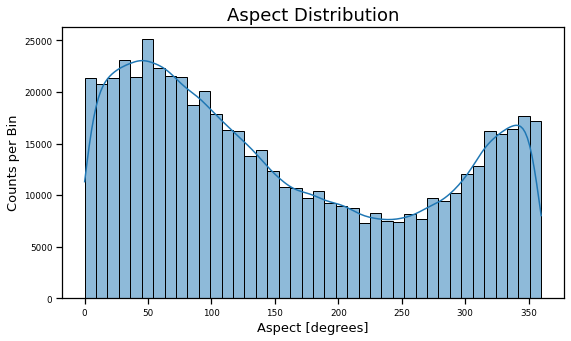

In [11]:
plot_a_distribution('Aspect', 'all_hist')

The histogram shows a bimodal distribution, with peaks at about 50 degrees (north-east) and 350 degrees (north-west). The fact that a broad peak around due north is being split is no doubt contributing to the wonky averages and medians that I am calculating. The raw math doesn't "know" that north-east and north-west are only 90 degrees apart on a compass; it is seeing them as about 300 degrees apart, and dutifully adding and dividing based on the numbers given to it. This is why I did the aspect "transformation" that I did: essentially, it transfers the split from 0 degrees to 180 degrees and allows the peak at 50 degrees to be "reconstructed," in a way. I will illustrate this directly below. One could think about the transformation as wrapping 360 degrees to overlap with zero, cutting the tube of paper at 180 degrees, and laying the result back out on the number line. <br>
If my assertion is correct, doing this "wrap and cut" should solve the problem with counterintuitive averages and medians, though it will make thinking about that is going on around due south a bit harder to visualize. Let's now look at the summary statistics of the 'AspectMod' column:

In [123]:
mod_aspect_stats = get_summary_stats('AspectMod')
print(mod_aspect_stats)

          Cover_Type Avg Median  Min  Max             Quartiles    IQR
0         Spruce/Fir  18     25 -179  180   [-39.0, 25.0, 80.0]  119.0
1     Lodgepole Pine  21     34 -179  180   [-42.0, 34.0, 92.0]  134.0
2     Ponderosa Pine  18     20 -179  180  [-54.0, 20.0, 106.0]  160.0
3  Cottonwood/Willow  59     91 -179  180   [15.0, 91.0, 122.0]  107.0
4              Aspen  41     68 -179  180  [-14.0, 68.0, 106.0]  120.0
5        Douglas-fir   2      0 -179  180    [-40.0, 0.0, 44.0]   84.0
6          Krummholz  35     44 -179  180  [-20.0, 44.0, 101.0]  121.0


Thes averages and medians make much more sense to me: they tell me that trees like to grow on north-east facing surfaces ... well, all except for Cottonwood/Willow trees, which seem to prefer to grow on south-east facing surfaces. Looking at the histogram below, one can see a peak in values at about 50 degrees, which corresponds to approximately north-east, with a large spread from due west (-90 degrees) to due east (+90 degrees). The averages and medians of each cover type distribution fall within that peak, which makes a great deal of sense to me. Additionally, IRQs on the order of 100 make a bit more sense to me than IRQs on the order of 180. Indeed, we saw above that the Douglas-Fir's IRQ was 276, i.e. almost 3/4 of a circle; with the transformed values, the IRQ is down to about 80 degrees, or 1/5 of a circle. The latter seems much more reasonable to me than the former.

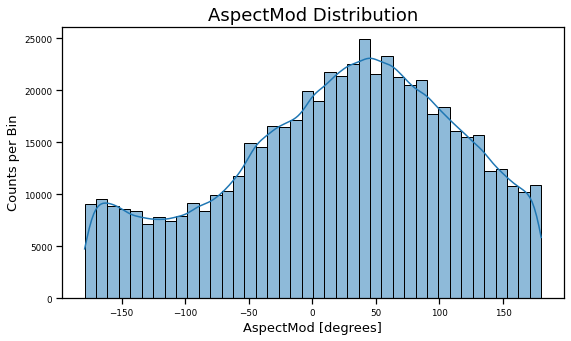

In [12]:
plot_a_distribution('AspectMod', 'all_hist')

The reader can now clearly see what my transformation did: it transferred the split in the data from due north to due south, allowing the large peak at about 50 degrees to be "reconstructed." I think this way of looking at the data is better from an interpretation and analysis standpoint, though I admit that it makes it harder to think about what is happening near due South, and it does make thinking about the angular measurements between due south and due north going clockwise a bit harder. (I suppose one could think of the latter as being measured counterclockwise from north to south but given negative values, but from a consistency-in-measurement-definition standpoint that doesn't make much sense.)<br>
<br>
Above, I have argued that transferring the split in the data from due north to due south, which allows for the "reconstruction" of a clear peak in the data between values of -100 degrees to 100 degrees, is a superior way of approaching the analysis of the data. I will continue to use 'AspectMod' to characterize the aspect feature of the data from here on in. As a first step, I plot a violin plot of the 'AspectMod' feature split by cover type:

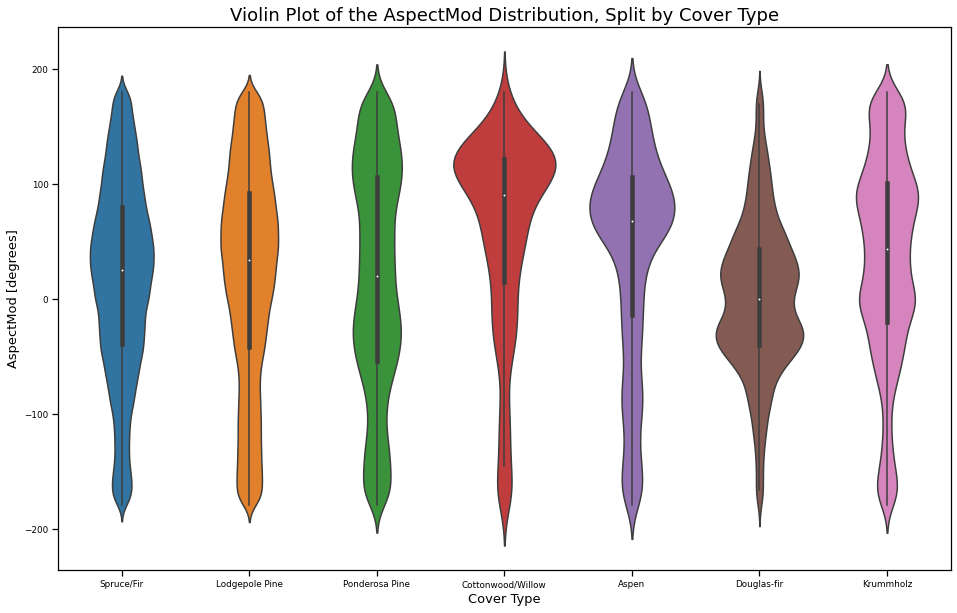

In [13]:
plot_a_distribution('AspectMod', 'violin')

My first reaction upon seeing this plot was, "Wow, trees will grow anywhere!" No matter the aspect, there were at least a few trees growing on the surface. Also, the cover types can once again be grouped loosely into three groups. One group of trees (Cottonwoo/Willow and Aspen) have definite preferences in terms of where they "want" to grow. Cottonwood/Willows prefer slopes which face a little bit south of east, whereas aspens prefer northeastern-facing slopes. Both aspect distributions show one clear peak at the trees' preferred directions, with broad tails extending the rest of the compass directions. Another group of trees prefers to grow in one of two directions, with only a few trees growing in other places. Douglas-firs clearly prefer to grow either on northwest or noreast facing surfaces; Krummholzes prefer surfaces which are just west of north, as well as eastern-facing surfaces; Ponderosa Pines prefer northwestern or eastern-facing surfaces. The last group of trees has a mild preference for one direction, but will pretty much grow anywhere. Both Spruce/Firs and Lodgepole Pines have a mild preference for growing on northeastern-facing surfaces, but the peaks are not very sharp and are quite wide. It should be noted that different trees populated each elevation "group" and each aspect "group," so there do not seem to be any trends in terms of what elevation trees like and what aspects they like.
<br>
Since I transformed the aspect into something which didn't split up northwest and northeast to different ends of the number line, the plot of individual cover type histograms of aspect is much more informative than it was before I did the transformation. I plot this plot below:

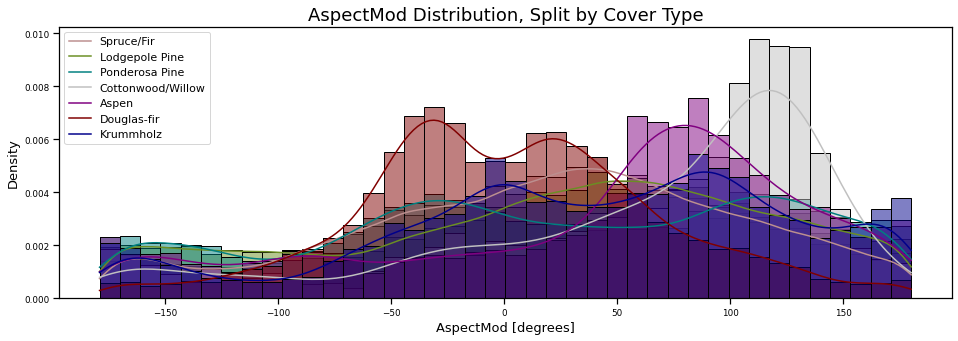

In [125]:
plot_a_distribution('AspectMod', 'split_hist')

One disadvantage of this plot is that, since all types of trees will grow on any aspect, the low-density portion of the histogram plot is quite croweded and doesn't allo for much comparison between cover types. However, Cottonwood/Willow trees have a clear spike between aspects of 100 degrees and 150 degrres (southeast and a little bit south of east), and Aspens have a clear spike between 50 degrees and 100 degrees (east and a little bit north of east). One can also see two peaks for Spruce/Firs, one between -50 degrees and 0 degrees (northwest and just west of north) and another between 0 and 50 degrees (northeast and just east of north). If one looks at the KDE distributions (plotted as solid lines over the histograms), one can see two shallow, broad peaks in the Krummholz aspect distribution: one is at about 0 degrees (due north) and another at about 90 degrees (due east). The other distributions are much harder to distinguish as their peaks are shallow and overlap a great deal with the other distributions. <br>
In short, it appears as though aspect and cover type are associated; at least one distribution (Cottonwood/Willow) seems to be very different from the other distributions. I now run a Welch ANOVA analysis on the aspect data, with a follow-up Games-Howell post-hoc test. My significance threshhold will once again be 0.001.

In [126]:
test_for_association_welch('AspectMod')

Welch ANOVA p-value for AspectMod/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)       T   pval
0               Aspen  Cottonwood/Willow   40.987   58.901  -9.339  0.001
1               Aspen        Douglas-fir   40.987    2.394  35.620  0.001
2               Aspen          Krummholz   40.987   34.529   5.638  0.001
3               Aspen     Lodgepole Pine   40.987   20.683  20.802  0.001
4               Aspen     Ponderosa Pine   40.987   17.728  21.246  0.001
5               Aspen         Spruce/Fir   40.987   18.039  23.476  0.001
6   Cottonwood/Willow        Douglas-fir   58.901    2.394  32.569  0.001
7   Cottonwood/Willow          Krummholz   58.901   34.529  13.736  0.001
8   Cottonwood/Willow     Lodgepole Pine   58.901   20.683  22.885  0.001
9   Cottonwood/Willow     Ponderosa Pine   58.901   17.728  23.635  0.001
10  Cottonwood/Willow         Spruce/Fir   58.901   18.039  24.456

The Welch's ANOVA test indicated a significant difference between at least one aspect distribution and one other aspect distribution. Once again, I suspect that the actual p-value is almost certainly non-zero, but falls below the precision that the test is able to report. The post-hoc Games-Howell pairwise test further indicates that, with one exception, the aspect distributions are signifcantly different from each other. The lone exception is the aspect distributions of Ponderosa Pines and Spruce/Firs; the p-value resulting from that test is 0.9, meaning that there is a good likelihood that the difference in means I am seeing for the distributions is due to random chance. <br>
I should of course note that, because of the circular nature of the measurements (cardinal directions are mapped to angles measured clockwise from due north), this sort of statistical analysis may not be the most appropriate analysis to run on aspect data. This is because the calculations are being performed assuming base-10 numbers, and the actual measurements are base 60 with a wrap-around (360 degrees and 0 degrees are the same angular measurement). This is perhaps the lone quantitative distribution in this problem set for which a visual determination of histogram overlap is appropriate, and that reveals that at least one distribution has a very different shape and peak from the other distributions. Therefore, I will also include aspect in my deep learning model of forest cover type.

***
<a id="Section4D"></a> 

<h5> D: Slope</h5>

Since values of slope range from 0 to 66, I am assuming that slope is being measured in degrees rather than meters. Fortunately, I don't have to worry much about doing any calculations on the slope column like I did to the aspect column; this is because there is no "wrap-around" value for slope, just a maximum at 90 degrees. This means that a slope of 66 degrees is very different and very much steeper than a slope of, say, 10 degrees. Thus, a column of slopes measured in degrees much easier to interpret and work with than a column of aspects measured in degrees, which is always nice from an exploratory data analysis standpoint. Let us have a look at the average and median values of slope, as well as IQR and minimum/maximum values, for each cover type class.

In [50]:
slope_stats = get_summary_stats('Slope')
print(slope_stats)

          Cover_Type Avg Median  Min  Max           Quartiles   IQR
0         Spruce/Fir  13     12    0   56   [8.0, 12.0, 17.0]   9.0
1     Lodgepole Pine  14     13    0   66   [8.0, 13.0, 18.0]  10.0
2     Ponderosa Pine  21     21    0   50  [14.0, 21.0, 27.0]  13.0
3  Cottonwood/Willow  19     19    0   46  [11.0, 19.0, 26.0]  15.0
4              Aspen  17     16    0   51  [10.0, 16.0, 22.0]  12.0
5        Douglas-fir  19     19    0   54  [13.0, 19.0, 25.0]  12.0
6          Krummholz  14     13    0   51   [9.0, 13.0, 18.0]   9.0


When it comes to the slope of the surface a tree is to grow upon, there appear to be two broad groups of trees: one group of trees pefers shallow slopes (Spruce/Fir, Lodgepole Pine, Krummholz), and the other prefers steeper slopes (Douglas-fir, Ponderosa Pine, Cottonwood/Willow). Aspens again are the "caught in the middle" type, as they were for elevation. <br>
Let's have a look at the distribution of slopes for the full data set:

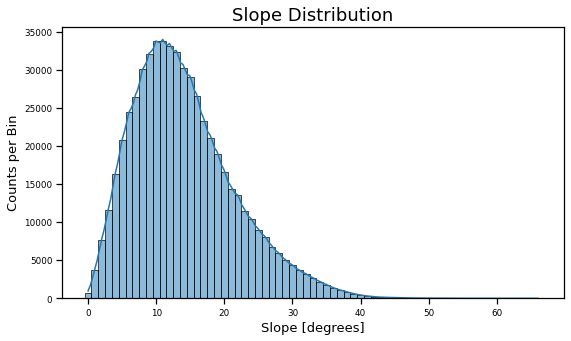

In [85]:
plot_a_distribution('Slope', 'all_hist', nbins=70)

This is a nice, smooth distribution with a clear peak at about 12 or so degrees, and a long tail toward steeper values of slope. <br>
Now, let's look at a violin plot of the slope distribution split up by cover type:

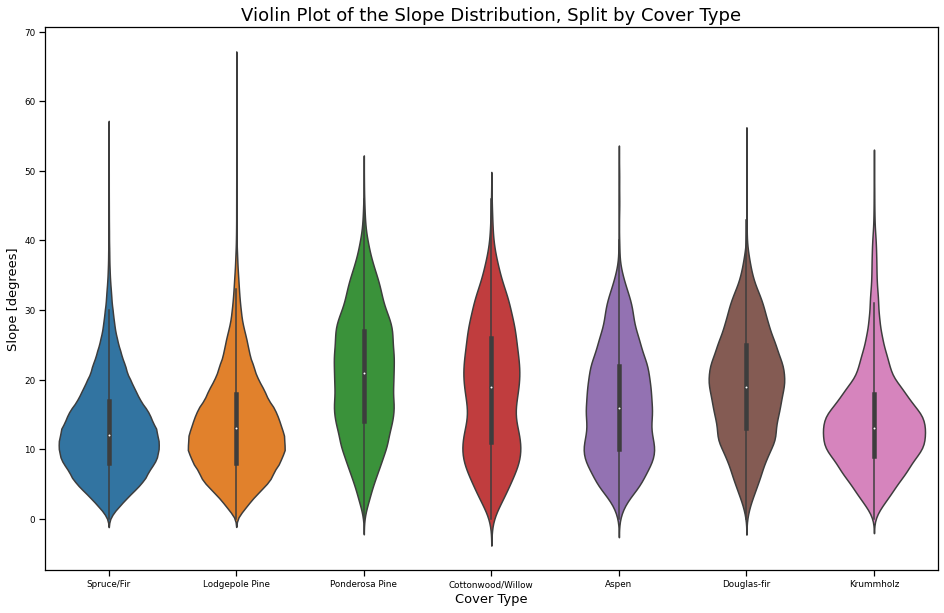

In [87]:
plot_a_distribution('Slope', 'violin')

Looking at the shapes of the slope distributions, I can see that my grouping of trees into two groups based on the slopes they prefer translates directly into distribution shape. The group of trees which prefer shallower slopes (Spruce/Fir, Lodgepole Pine, and Krummholz) has distributions which rise quickly to a peak at around 10 to 12 degrees, decay slowly, and largely tail off by about 40 degrees or so. The shapes of the distributions are all similar, with much more defined peaks than the other distributions display. One can contrast these shapes with the shapes of the group of trees which prefer steeper slopes (Ponderosa Pine, Cottonwood/Willow, Douglas-fir, and Aspen): the distributions of this second group are much broader, with much less defined peaks, and which extend pretty much from 0 degrees to 40 degrees. I am struck by the lack of a pronounced peak in the distributions of the second group; there is a shallow peak for the Cottonwood/Willow distribution at about 8 degrees, and one in the Douglas-fir distribution at about 20 degrees, but overall the distributions look pretty flat. <br>
I will now plot the individual slope distributions of each cover type to see if my observations from the violin plot are mirrored there.

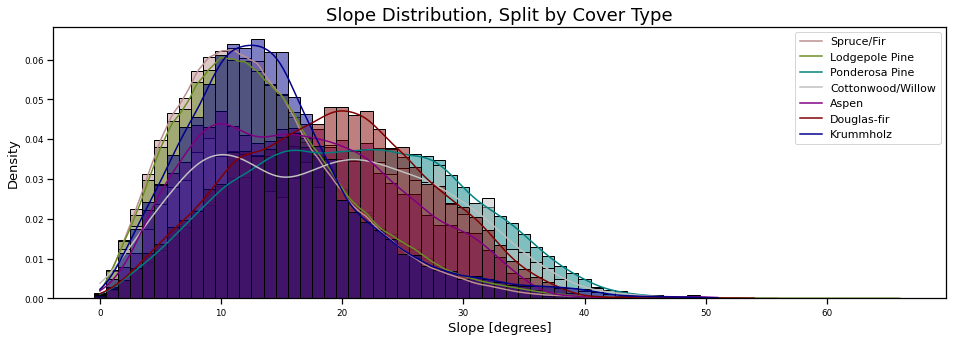

In [88]:
plot_a_distribution('Slope', 'split_hist', numofbins=70)

They are. The Lodgepole Pine, Spruce/Fir, and Krummholz distributions are sharply-peaked and narrow, whereas the Ponderosa Pine and Douglas-fir distriibutions are wide and have shallow, very broad peaks. Both the Aspen and Cottonwood/Willow distributions look to be bimodal, with the first peak of each distribution being fairly narrow but the second peak being shallower and much broader. <br>
Thus, there is ample visual evidence to hypothesize that slope and cover type are related: knowing something about cover type tells you something about slope, broadly speaking. To mathematically test this assertion, I once again run a Welch ANOVA test on the slope distributions, with a post-hoc Games-Howell test to see which distributions are significantly different from each other. Again, my <i>a priori</i> chosen significance threshhold is 0.001.

In [21]:
test_for_association_welch('Slope')

Welch ANOVA p-value for Slope/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)        T   pval
0               Aspen  Cottonwood/Willow   16.641   18.529   -9.569  0.001
1               Aspen        Douglas-fir   16.641   19.049  -23.221  0.001
2               Aspen          Krummholz   16.641   14.256   24.067  0.001
3               Aspen     Lodgepole Pine   16.641   13.550   36.211  0.001
4               Aspen     Ponderosa Pine   16.641   20.770  -42.641  0.001
5               Aspen         Spruce/Fir   16.641   13.127   41.053  0.001
6   Cottonwood/Willow        Douglas-fir   18.529   19.049   -2.761  0.084
7   Cottonwood/Willow          Krummholz   18.529   14.256   22.997  0.001
8   Cottonwood/Willow     Lodgepole Pine   18.529   13.550   27.836  0.001
9   Cottonwood/Willow     Ponderosa Pine   18.529   20.770  -12.141  0.001
10  Cottonwood/Willow         Spruce/Fir   18.529   13.127 

All slope distributions are significantly different from all other slope distributions, save for those of Cottonwood/Willows and Douglas-firs. (Recall my discussion above about the value of 0.0 from the Welch ANOVA test almost certainly not being zero, just very small, and the 0.001 significance level threshhold issue discussed in section 3 as regards the Games-Howell post hoc test.) Thus, I am justified in including slope among the features to be included in my neural network model of forest cover type.

***
<a id="Section4E"></a> 

<h5> E: Horizontal Distance to Hydrology </h5>

It has been a bit challenging to determine what exactly is meant by "horizontal distance to hydrology." I was able to find the following definition of hydrologic distance from <a href = "http://www.gishydro.eng.umd.edu/documents/train_manual/old/flowlengths.pdf">this document</a>: hydrologic distance (or "flow length") is the distance from any point in the watershed to the watershed outlet. The document indicates that hydrologic distance is measured along the direction of flow, not "as the crow flies." If I interpret this correctly, a point in the watershed could be a tree, and so "horizontal distance to hydrology" would be the horizontal component of this distance along the direction of the flow from the tree's location to the watershed outlet. (While not quite on topic, I did want to note that <a href="https://www.fs.usda.gov/treesearch/pubs/24048">this paper</a> by Henry W. Anderson, Marvin D. Hoover, and Kenneth G. Reinhart seems to be the most cited study of the effects of forest management on floods, sedimentation, and water supply. Since Codecademy tells me that the data in this data set comes from forests with minimal human-caused disturbances, the methods of such a study likely wouldn't apply to this data, but the idea that forests impact the water supply around them does seem reasonable to me.) <br>
If my interpretation that horizontal distance to hydrology is the horizontal component of the distance along the flow of water from a tree's location to the watershet outlet, I would expect Cottonwood/Willows to have very small horizontal distances to hydrology, as I know they require a lot of water as young trees to grow and are often found very near water sources. I frankly don't know what I'd expect for other tree types, but I wouldn't expect them to stray more than a mile or so from a watershed outlet if given their druthers of where to grow. Let us see what the average and median values of horizontal distance to hydrology are to see if my intuition yields something reasonable.

In [51]:
hdth_stats = get_summary_stats('Horizontal_Distance_To_Hydrology')
print(hdth_stats)

          Cover_Type  Avg Median  Min   Max              Quartiles    IQR
0         Spruce/Fir  271    218    0  1200   [95.0, 218.0, 400.0]  305.0
1     Lodgepole Pine  280    240    0  1397  [120.0, 240.0, 391.0]  271.0
2     Ponderosa Pine  210    190    0   726   [90.0, 190.0, 301.0]  211.0
3  Cottonwood/Willow  107     30    0   551     [0.0, 30.0, 192.0]  192.0
4              Aspen  212    175    0  1100   [85.0, 175.0, 300.0]  215.0
5        Douglas-fir  160    134    0   644   [60.0, 134.0, 240.0]  180.0
6          Krummholz  357    283    0  1323  [120.0, 283.0, 525.0]  405.0


As would match my intuition if my interpretation of horizontal distance to hydrology is correct, Cottonwood/Willow trees have the smallest average distance to hydrology and by far the lowest median value. That does not, of course, make my interpretation correct, but it <i>does</i> indicate that, for at least one tree type, it is reasonable. Save for Douglas-fir trees, all other cover types have much large average and median distances to hydrology, which is reasonble if they are not as water-loving as Cottonwood/Willows. I also see that the maximum horizontal distance to hydrology is 1.397 km (i.e., 1,397 m), which is about 0.87 miles. Hence, trees aren't straying much more than about a mile (horizontally) from their local watershed outlet, which again matches my intuition. Ponderosa Pines, Cottonwood/Willows, Aspens, and Douglas-firs all have comparable IQRs of 200 or so m (that's about 0.12 miles), while Spruce/Firs, Lodgepole Pines, and Krummholzes all have much larger IQRs. <br>
Let me see what the distribution of horizontal distance to hydrology looks like for the full data set:

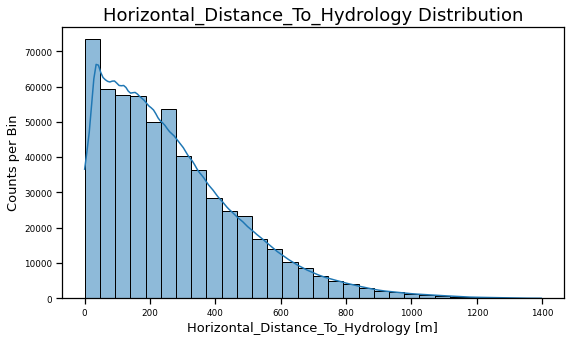

In [91]:
plot_a_distribution('Horizontal_Distance_To_Hydrology', 'all_hist', nbins=30)

It appears that, when measuring horizontal distance to hydrology, cardinal direction doesn't matter; that is to say, horizontal distance to hydrology seems to be measured radially outward from the origin, which I take to be the location of the local watershed outlet. I infer this because there are no negative values. Given this assumption, the histogram I am seeing makes a great deal of sense given my interpretation of horizontal distance to hydrology. Trees don't like to grow far from water sources. This is why there is a bit spike around 0 m, and why the distribution tails off before 1,400 m. There seem to be an exponential decay in counts past about 300 m or so, with a shallower decay betwen 0 m and 300 m. <br>
Having seen the horizontal distance to hydrology distribution for the full data set, let's see what it looks like for the distribution split by cover type:

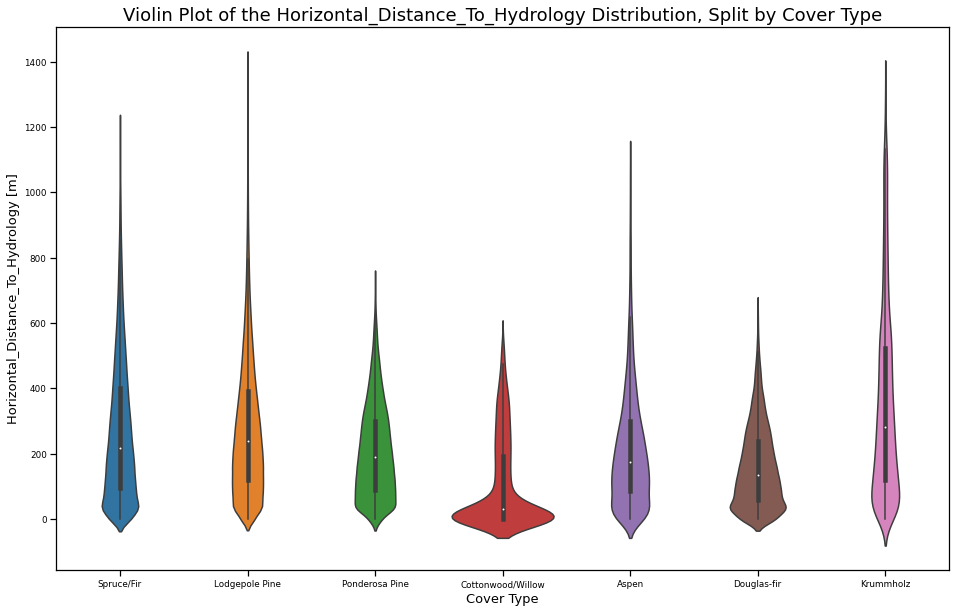

In [89]:
plot_a_distribution('Horizontal_Distance_To_Hydrology', 'violin')

What is the most striking to me about this violin plot is how different the distribution of Cottonwood/Willow distances is compared to every other tree type. This distribution features a sharp peak at about 10 or 10 m, a sharp drop-off after the peak, and a tail that doesn't extend past 600 m. These trees clearly do not want to stray far from a water outlet. As for the other cover types, they can be grouped into two groups. One group (Ponderosa Pine and Douglas-fir) features a broad but identifiable peak at about 20 or 30 m and a long tail which does not continue past 800 m. The other group (Spruce/Fir, Lodgepole Pine, Aspen, and Krummholz) have a very shallow, very broad peak at about 20 or 30 m or so, and significant tails going out well past 800 m. It seems to me that the latter group of trees doesn't really care how close it is (horizontally) to a water outlet; the former group wants to be sort of close to a water outlet, but isn't too particular about the exact distance so long as it doesn't get too big. All distributions except for Cottonwood/Willow are very broad, so while it would be easy to tell that cover type apart from all others based on horizontal distance to hydrology alone, the other cover types would be much harder to tell apart. Still, if only to differentiate Cottonwood/Willows from other trees, there is valuable information about horizontal distance to hydrology which comes from knowing cover type. <br>
Because of the large amount of overlap between horizontal distance to hydrology distributions for everything but Cottonwood/Willows, I did not make a plot of each cover type's histogram. I have included the function call if the reader wants to test my assertion that the plot does not provide useful insight into the data. Please feel free to run the cell below if you would like.

In [ ]:
plot_a_distribution('Horizontal_Distance_To_Hydrology', 'split_hist')

Just based on the violin plot alone, it seems likely that there is a significant difference between the Cottonwood/Willow horizontal distance to hydrology distribution and at least one other horizontal distance to hydrology distribution. I will mathematically check this by performing a Welch ANOVA test on the data. Since it's quite likely that the test will indicate a significant difference between at least one horizontal distance to hydrology distribution and at least one other horizontal distance to hydrology distribution, I will go ahead and run a post-hoc Games-Howell test on the data as well. As in all the cases above, my significance threshhold will be 0.001.

In [24]:
test_for_association_welch('Horizontal_Distance_To_Hydrology')

Welch ANOVA p-value for Horizontal_Distance_To_Hydrology/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)        T   pval
0               Aspen  Cottonwood/Willow  212.355  106.935   32.533  0.001
1               Aspen        Douglas-fir  212.355  159.853   25.365  0.001
2               Aspen          Krummholz  212.355  356.995  -52.337  0.001
3               Aspen     Lodgepole Pine  212.355  279.916  -35.867  0.001
4               Aspen     Ponderosa Pine  212.355  210.276    1.045  0.900
5               Aspen         Spruce/Fir  212.355  270.555  -30.616  0.001
6   Cottonwood/Willow        Douglas-fir  106.935  159.853  -18.709  0.001
7   Cottonwood/Willow          Krummholz  106.935  356.995  -74.211  0.001
8   Cottonwood/Willow     Lodgepole Pine  106.935  279.916  -64.180  0.001
9   Cottonwood/Willow     Ponderosa Pine  106.935  210.276  -37.305  0.001
10  Cottonwood/Willow         Sp

The Welch ANOVA analysis does indicate a significant difference between at least one horizontal distance to hydrology distribution and at least one other such distribution. (Once again, the 0.0 is likely not an exact value; the true value likely falls below the lower limit of what the test was programmed to return.) Upon running a post-hoc Games-Howell test in light of the Welch ANOVA result, I see that the only horizontal distance to hydrology distributions that <i>aren't</i> significantly different are the Aspen and Ponderosa Pine distributions. Given the broadness and shallowness of the distributions, it surprises me that more of the distributions weren't found to be similar to each other, but clearly the Cottonwood/Willow distribution is significantly different from all of the others. Thus, I am justified in including horizontal distance to hydrology among the features to be passed on to my deep learning model of forest cover type.

***
<a id="Section4F"></a> 

<h5> F: Vertical Distance to Hydrology </h5>

My interpretation of vertical distance to hydrology is that it is the vertical component of the distance along the direction of the flow from the tree's location to the watershed outlet. (See my discussion in Section 4E for a definition of hydrologic distance and my interpretation of horizontal distance to hydrology.) Here, the zero of the measurement seems to be at the elevation of the watershed outlet, so both positive and negative values of vertical distance to hydrology are possible. If this interpretation is true, I would expect three things. First and foremoest, I would expect that Cottonwood/Willow trees will have vertical distances to hydrology close to 0, as they are water-loving trees and will "want" to be as close to the watershed outlet as possible. Secondly, I'd expect trees to not want to stray more than a few hundred feet vertically from the watershed outlet; if the maximum vertical distance was, say, 500 feet, that would correspond to 152 meters. Lastly, I'd expect for trees to not want to be too far downhill from a watershed outlet, as they either won't get much water if the outlet is doing its job, or get flooded if the outlet is overwhelmed. Let us take a look at the summary statistics of the vertical distance to hydrology column to see if my expectations are borne out.

In [52]:
vdth_stats = get_summary_stats('Vertical_Distance_To_Hydrology')
print(vdth_stats)

          Cover_Type Avg Median  Min  Max           Quartiles   IQR
0         Spruce/Fir  42     24 -156  431   [4.0, 24.0, 62.0]  58.0
1     Lodgepole Pine  46     30 -173  601   [8.0, 30.0, 66.0]  58.0
2     Ponderosa Pine  62     50 -134  312  [18.0, 50.0, 95.0]  77.0
3  Cottonwood/Willow  41      6  -25  270    [0.0, 6.0, 72.0]  72.0
4              Aspen  51     35 -134  265   [6.0, 35.0, 81.0]  75.0
5        Douglas-fir  45     34 -126  288   [8.0, 34.0, 73.0]  65.0
6          Krummholz  69     43  -84  412  [8.0, 43.0, 107.0]  99.0


At least one of my expectations seems to have been borne out: Cottonwood/Willow trees have the smallest average and median vertical distances to hydrology, as well as the smallest range of maximum and mimimum values. (Interestingly, those trees do not have the smallest IQR, though: Douglas-firs do.) It does seem as though 25% or so of trees from all species don't mind being at a lower elevation than the watershed outlet, which seems odd to me, but they seem to be lower than the outlet only by 500 or 600 feet. (I base the 25% number on Q1 being so close to 0 for all distributions, except perhaps for Ponderosa Pines.) Trees are much more comfortable being at a higher elevation than the watershed outlet, and while that does make sense to me--they'll get a share of any water flowing downhill to the watershed outlet past them--they grow at much higher elevations than I expected, with the maximum being about 600 m (about 1,970 feet, or about 0.37 miles). Maybe my interpretation of vertical distance to hydrology is wrong, and maybe it isn't, but at least one of my expectations matches what I got. <br>
Let's have a look at the distribution of vertical distances to hydrology for the full data set:

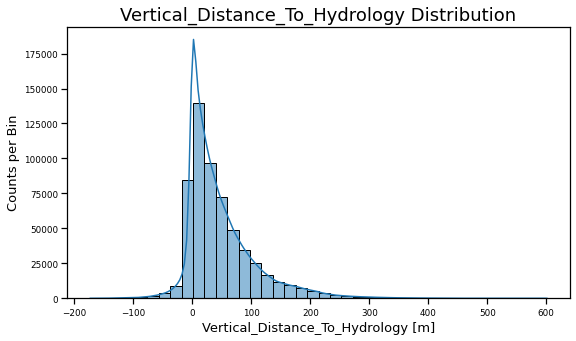

In [94]:
plot_a_distribution('Vertical_Distance_To_Hydrology', 'all_hist', numofbins=30)

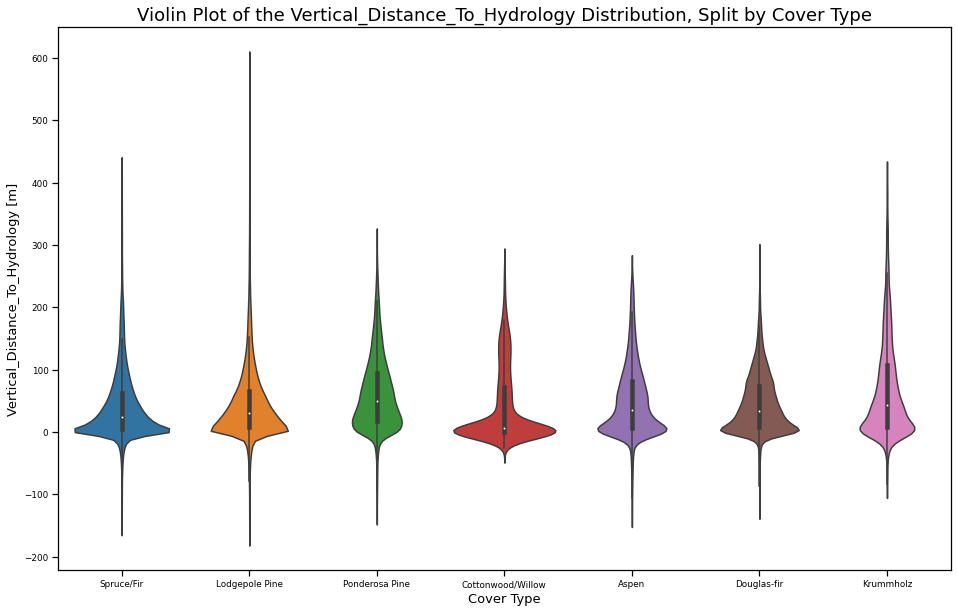

In [92]:
plot_a_distribution('Vertical_Distance_To_Hydrology', 'violin')

In [27]:
test_for_association_welch('Vertical_Distance_To_Hydrology')

Welch ANOVA p-value for Vertical_Distance_To_Hydrology/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)       T   pval
0               Aspen  Cottonwood/Willow   50.610   41.187   7.400  0.001
1               Aspen        Douglas-fir   50.610   45.437   7.471  0.001
2               Aspen          Krummholz   50.610   69.474 -23.160  0.001
3               Aspen     Lodgepole Pine   50.610   45.884   7.834  0.001
4               Aspen     Ponderosa Pine   50.610   62.447 -17.658  0.001
5               Aspen         Spruce/Fir   50.610   42.157  13.946  0.001
6   Cottonwood/Willow        Douglas-fir   41.187   45.437  -3.597  0.006
7   Cottonwood/Willow          Krummholz   41.187   69.474 -22.500  0.001
8   Cottonwood/Willow     Lodgepole Pine   41.187   45.884  -4.150  0.001
9   Cottonwood/Willow     Ponderosa Pine   41.187   62.447 -18.187  0.001
10  Cottonwood/Willow         Spruce/Fir   41

***
<a id="Section4G"></a> 

<h5> G: Horizontal Distance to Roadways </h5>

In [53]:
hdtr_stats = get_summary_stats('Horizontal_Distance_To_Roadways')
print(hdtr_stats)

          Cover_Type   Avg Median  Min   Max                 Quartiles     IQR
0         Spruce/Fir  2615   2389    0  6632  [1400.0, 2389.0, 3624.0]  2224.0
1     Lodgepole Pine  2430   2039    0  7117  [1138.0, 2039.0, 3408.0]  2270.0
2     Ponderosa Pine   944    853    0  3436    [458.0, 853.0, 1290.0]   832.0
3  Cottonwood/Willow   914    949   67  1702    [624.0, 949.0, 1218.0]   594.0
4              Aspen  1350   1282   30  5206   [459.0, 1282.0, 1956.0]  1497.0
5        Douglas-fir  1037    966    0  3092    [600.0, 966.0, 1392.0]   792.0
6          Krummholz  2738   2654  451  5463  [1742.0, 2654.0, 3729.0]  1987.0


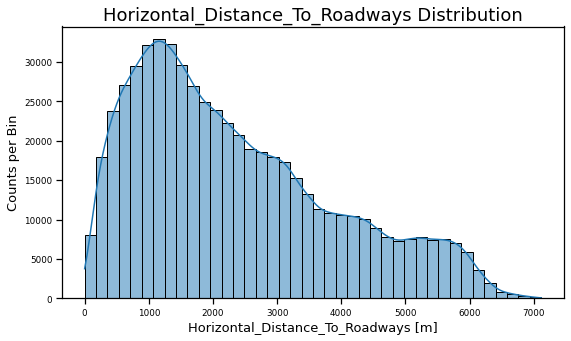

In [95]:
plot_a_distribution('Horizontal_Distance_To_Roadways', 'all_hist')

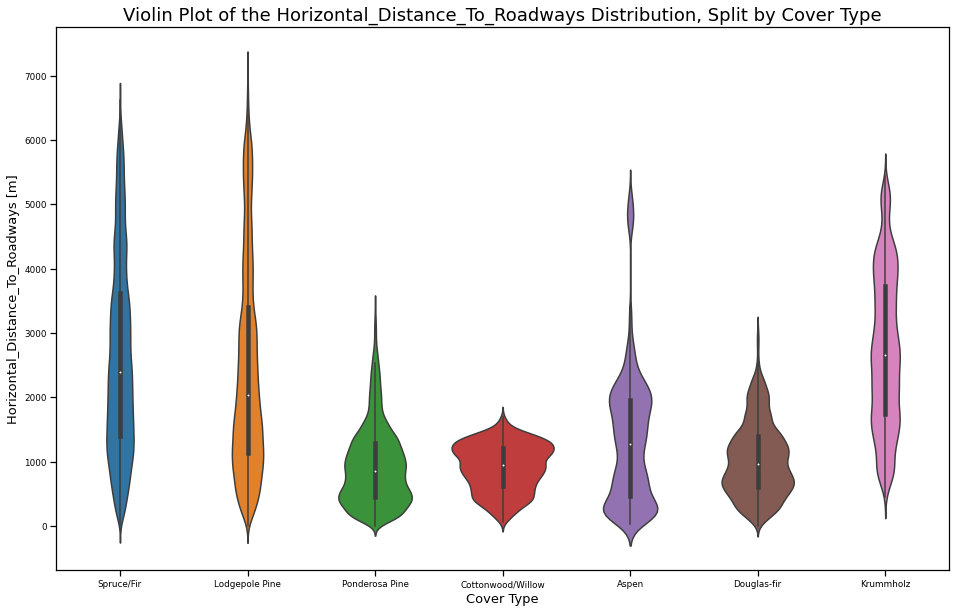

In [96]:
plot_a_distribution('Horizontal_Distance_To_Roadways', 'violin')

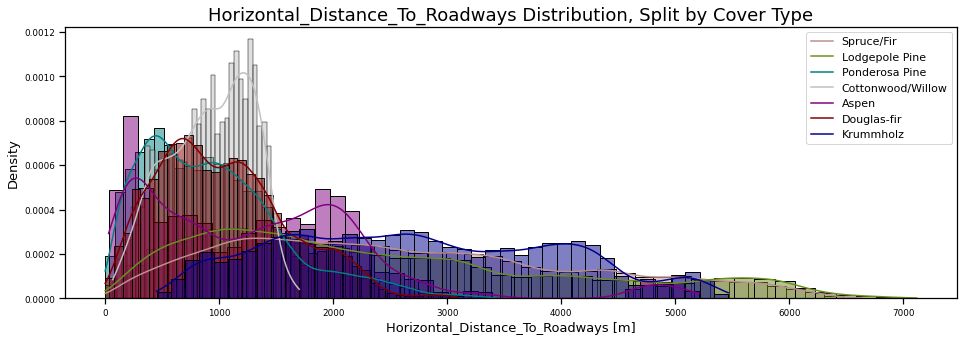

In [97]:
plot_a_distribution('Horizontal_Distance_To_Roadways', 'split_hist')

In [30]:
test_for_association_welch('Horizontal_Distance_To_Roadways')

Welch ANOVA p-value for Horizontal_Distance_To_Roadways/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B   mean(A)   mean(B)        T   pval
0               Aspen  Cottonwood/Willow  1349.766   914.199   34.032  0.001
1               Aspen        Douglas-fir  1349.766  1037.170   27.033  0.001
2               Aspen          Krummholz  1349.766  2738.250 -102.016  0.001
3               Aspen     Lodgepole Pine  1349.766  2429.531  -96.882  0.001
4               Aspen     Ponderosa Pine  1349.766   943.941   36.221  0.001
5               Aspen         Spruce/Fir  1349.766  2614.835 -112.899  0.001
6   Cottonwood/Willow        Douglas-fir   914.199  1037.170  -14.958  0.001
7   Cottonwood/Willow          Krummholz   914.199  2738.250 -167.126  0.001
8   Cottonwood/Willow     Lodgepole Pine   914.199  2429.531 -198.817  0.001
9   Cottonwood/Willow     Ponderosa Pine   914.199   943.941   -3.859  0.002
10  Cottonw

***
<a id="Section4H"></a> 

<h5> H: Hill Shade at 9AM </h5>

In [54]:
shade0900_stats = get_summary_stats('Hillshade_9am')
print(shade0900_stats)

          Cover_Type  Avg Median  Min  Max              Quartiles   IQR
0         Spruce/Fir  212    216    0  254  [199.0, 216.0, 230.0]  31.0
1     Lodgepole Pine  214    219    0  254  [201.0, 219.0, 232.0]  31.0
2     Ponderosa Pine  202    213   46  254  [173.0, 213.0, 236.0]  63.0
3  Cottonwood/Willow  228    235  127  254  [215.0, 235.0, 249.0]  34.0
4              Aspen  223    228  126  254  [211.0, 228.0, 241.0]  30.0
5        Douglas-fir  193    196    0  254  [168.0, 196.0, 220.0]  52.0
6          Krummholz  217    221   80  254  [202.0, 221.0, 234.0]  32.0


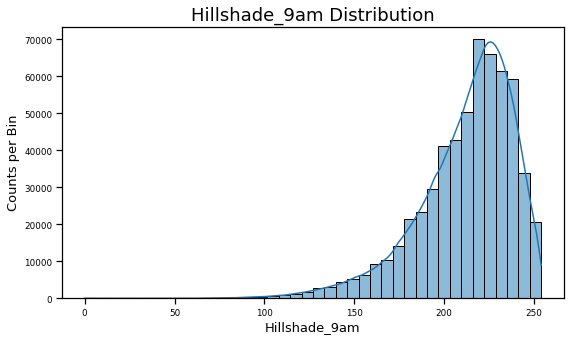

In [98]:
plot_a_distribution('Hillshade_9am','all_hist')

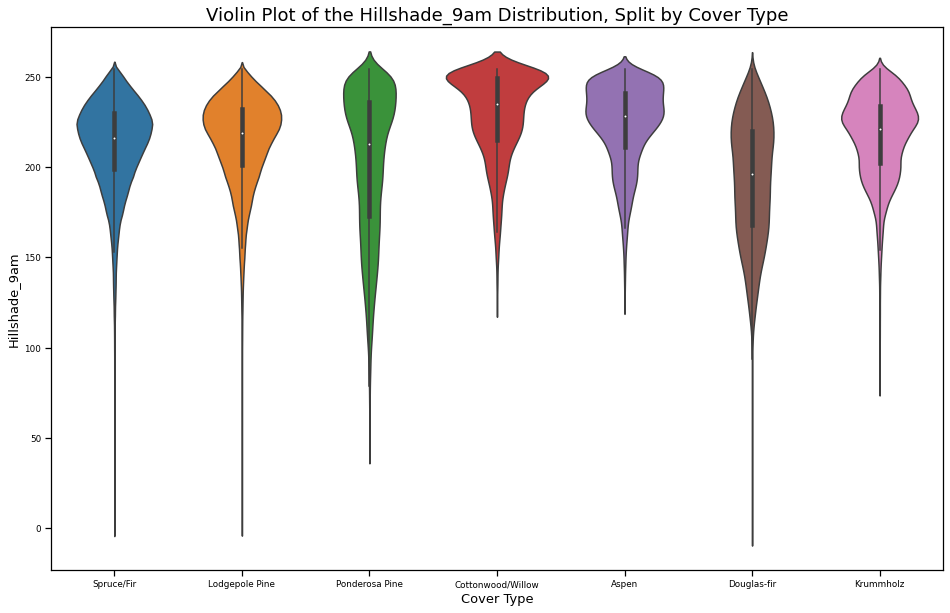

In [99]:
plot_a_distribution('Hillshade_9am','violin')

In [33]:
test_for_association_welch('Hillshade_9am')

Welch ANOVA p-value for Hillshade_9am/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)       T   pval
0               Aspen  Cottonwood/Willow  223.475  228.346  -9.434  0.001
1               Aspen        Douglas-fir  223.475  192.844  88.640  0.001
2               Aspen          Krummholz  223.475  216.968  22.837  0.001
3               Aspen     Lodgepole Pine  223.475  213.844  40.482  0.001
4               Aspen     Ponderosa Pine  223.475  201.918  67.963  0.001
5               Aspen         Spruce/Fir  223.475  211.999  47.938  0.001
6   Cottonwood/Willow        Douglas-fir  228.346  192.844  67.430  0.001
7   Cottonwood/Willow          Krummholz  228.346  216.968  23.276  0.001
8   Cottonwood/Willow     Lodgepole Pine  228.346  213.844  31.320  0.001
9   Cottonwood/Willow     Ponderosa Pine  228.346  201.918  51.990  0.001
10  Cottonwood/Willow         Spruce/Fir  228.346  211.999  35

***
<a id="Section4I"></a> 

<h5> I: Hill Shade at 12PM </h5>

In [55]:
shade1200_stats = get_summary_stats('Hillshade_Noon')
print(shade1200_stats)

          Cover_Type  Avg Median  Min  Max              Quartiles   IQR
0         Spruce/Fir  223    226   74  254  [214.0, 226.0, 236.0]  22.0
1     Lodgepole Pine  225    227    0  254  [215.0, 227.0, 239.0]  24.0
2     Ponderosa Pine  216    221   93  254  [200.0, 221.0, 238.0]  38.0
3  Cottonwood/Willow  217    220  137  254  [204.0, 220.0, 231.0]  27.0
4              Aspen  219    224   95  254  [205.0, 224.0, 238.0]  33.0
5        Douglas-fir  210    213   90  254  [196.0, 213.0, 227.0]  31.0
6          Krummholz  222    224   98  254  [211.0, 224.0, 236.0]  25.0


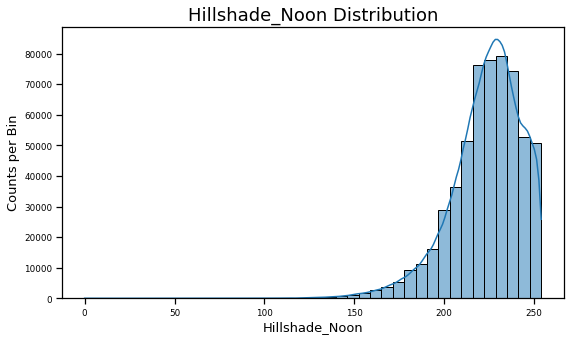

In [101]:
plot_a_distribution('Hillshade_Noon', 'all_hist')

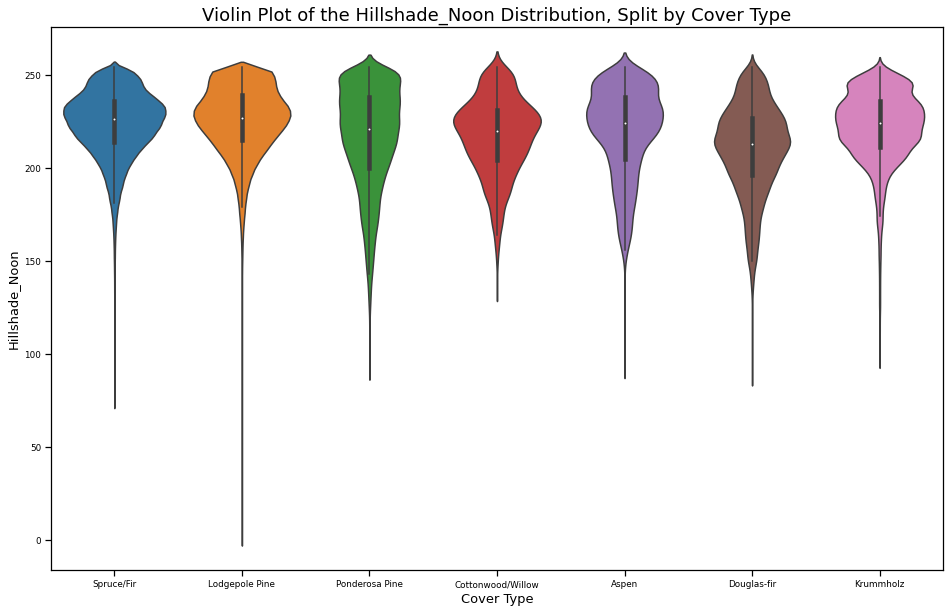

In [100]:
plot_a_distribution('Hillshade_Noon', 'violin')

In [36]:
test_for_association_welch('Hillshade_Noon')

Welch ANOVA p-value for Hillshade_Noon/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)       T   pval
0               Aspen  Cottonwood/Willow  219.036  216.997   4.301  0.001
1               Aspen        Douglas-fir  219.036  209.828  29.161  0.001
2               Aspen          Krummholz  219.036  221.746  -9.302  0.001
3               Aspen     Lodgepole Pine  219.036  225.327 -24.378  0.001
4               Aspen     Ponderosa Pine  219.036  215.827  10.870  0.001
5               Aspen         Spruce/Fir  219.036  223.430 -16.985  0.001
6   Cottonwood/Willow        Douglas-fir  216.997  209.828  16.294  0.001
7   Cottonwood/Willow          Krummholz  216.997  221.746 -11.231  0.001
8   Cottonwood/Willow     Lodgepole Pine  216.997  225.327 -20.792  0.001
9   Cottonwood/Willow     Ponderosa Pine  216.997  215.827   2.751  0.087
10  Cottonwood/Willow         Spruce/Fir  216.997  223.430 -1

***
<a id="Section4J"></a> 

<h5>  J: Hill Shade at 3PM </h5>

In [56]:
shade1500_stats = get_summary_stats('Hillshade_3pm')
print(shade1500_stats)

          Cover_Type  Avg Median  Min  Max              Quartiles   IQR
0         Spruce/Fir  144    144    0  254  [121.0, 144.0, 168.0]  47.0
1     Lodgepole Pine  143    142    0  254  [120.0, 142.0, 167.0]  47.0
2     Ponderosa Pine  140    142    0  251  [104.0, 142.0, 181.0]  77.0
3  Cottonwood/Willow  111    113    0  232   [74.0, 113.0, 149.0]  75.0
4              Aspen  122    128    0  236   [85.0, 128.0, 157.0]  72.0
5        Douglas-fir  148    150    0  248  [116.0, 150.0, 184.0]  68.0
6          Krummholz  135    140    0  229  [113.0, 140.0, 161.0]  48.0


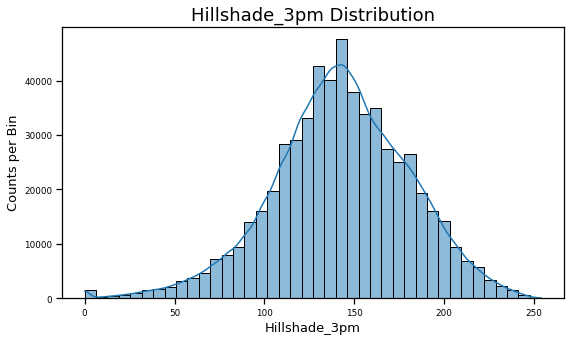

In [102]:
plot_a_distribution('Hillshade_3pm', 'all_hist')

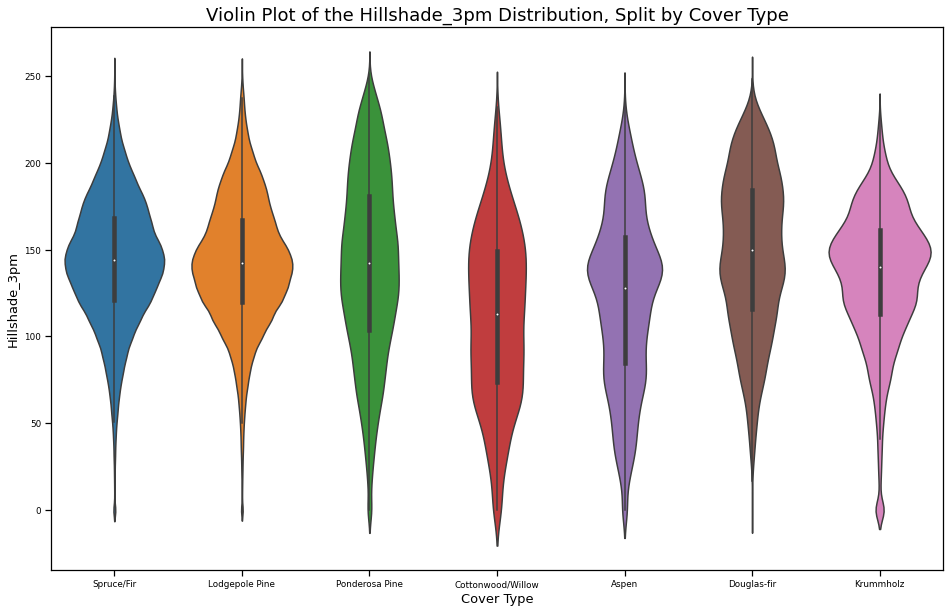

In [103]:
plot_a_distribution('Hillshade_3pm', 'violin')

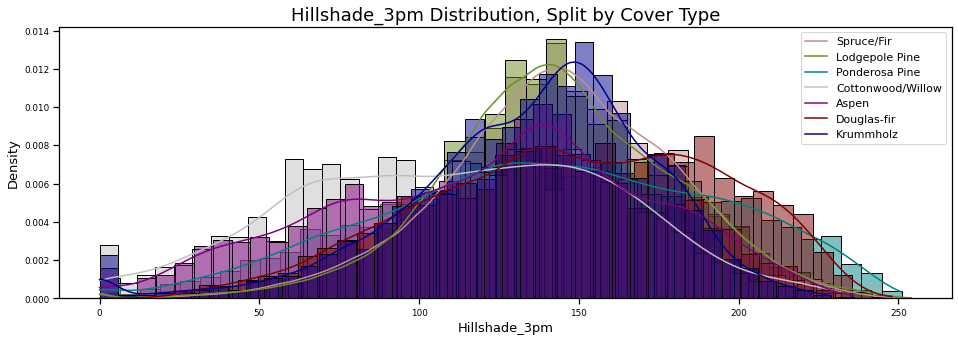

In [104]:
plot_a_distribution('Hillshade_3pm', 'split_hist')

In [39]:
test_for_association_welch('Hillshade_3pm')

Welch ANOVA p-value for Hillshade_3pm/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B  mean(A)  mean(B)       T   pval
0               Aspen  Cottonwood/Willow  121.921  111.393   9.858  0.001
1               Aspen        Douglas-fir  121.921  148.284 -43.012  0.001
2               Aspen          Krummholz  121.921  134.932 -22.615  0.001
3               Aspen     Lodgepole Pine  121.921  142.983 -41.172  0.001
4               Aspen     Ponderosa Pine  121.921  140.367 -31.913  0.001
5               Aspen         Spruce/Fir  121.921  143.875 -42.792  0.001
6   Cottonwood/Willow        Douglas-fir  111.393  148.284 -36.853  0.001
7   Cottonwood/Willow          Krummholz  111.393  134.932 -24.057  0.001
8   Cottonwood/Willow     Lodgepole Pine  111.393  142.983 -33.521  0.001
9   Cottonwood/Willow     Ponderosa Pine  111.393  140.367 -29.564  0.001
10  Cottonwood/Willow         Spruce/Fir  111.393  143.875 -34

***
<a id="Section4K"></a> 

<h5> K: Horizontal Distance to Fire Points </h5>

In [57]:
hdtfp_stats = get_summary_stats('Horizontal_Distance_To_Fire_Points')
print(hdtfp_stats)

          Cover_Type   Avg Median  Min   Max                 Quartiles     IQR
0         Spruce/Fir  2009   1825    0  7118  [1100.0, 1825.0, 2642.0]  1542.0
1     Lodgepole Pine  2168   1846    0  7173  [1173.0, 1846.0, 2656.0]  1483.0
2     Ponderosa Pine   911    824    0  2888    [513.0, 824.0, 1201.0]   688.0
3  Cottonwood/Willow   859    806    0  1921    [466.0, 806.0, 1248.0]   782.0
4              Aspen  1578   1471   42  6321   [902.0, 1471.0, 1981.0]  1079.0
5        Douglas-fir  1055    942    0  2940    [642.0, 942.0, 1359.0]   717.0
6          Krummholz  2070   1969    0  4589  [1191.0, 1969.0, 2854.0]  1663.0


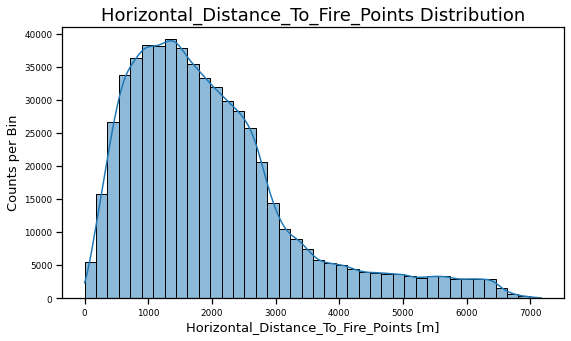

In [105]:
plot_a_distribution('Horizontal_Distance_To_Fire_Points', 'all_hist')

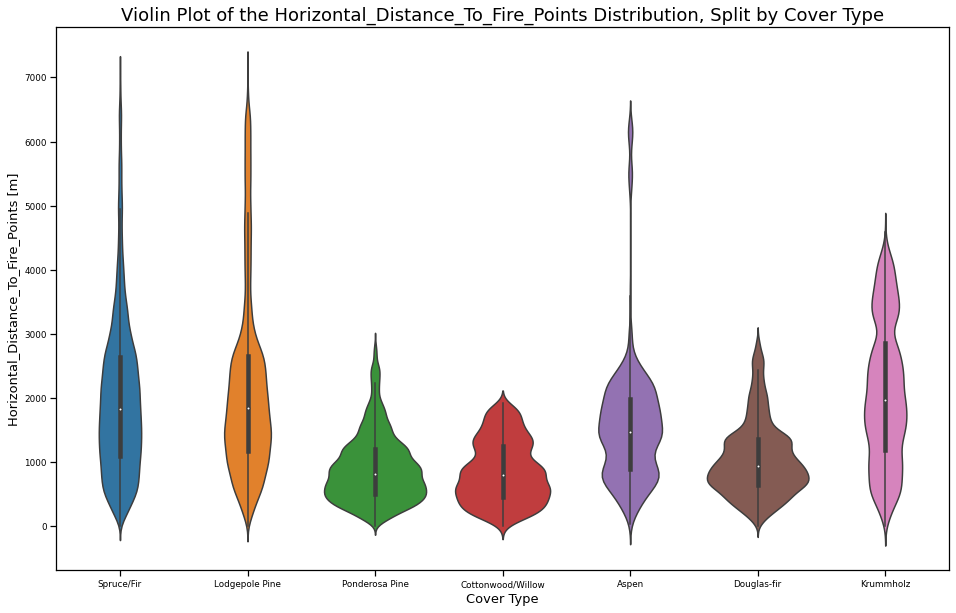

In [106]:
plot_a_distribution('Horizontal_Distance_To_Fire_Points', 'violin')

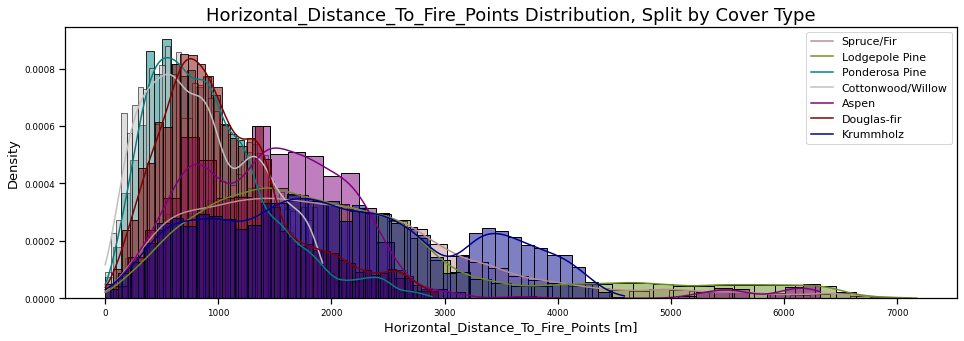

In [107]:
plot_a_distribution('Horizontal_Distance_To_Fire_Points', 'split_hist')

In [42]:
test_for_association_welch('Horizontal_Distance_To_Fire_Points')

Welch ANOVA p-value for Horizontal_Distance_To_Fire_Points/class association: 0.0

Games-Howell pairwise test for multiple comparisons of means:
                    A                  B   mean(A)   mean(B)        T   pval
0               Aspen  Cottonwood/Willow  1577.720   859.124   52.327  0.001
1               Aspen        Douglas-fir  1577.720  1055.351   46.996  0.001
2               Aspen          Krummholz  1577.720  2070.032  -38.673  0.001
3               Aspen     Lodgepole Pine  1577.720  2168.155  -55.896  0.001
4               Aspen     Ponderosa Pine  1577.720   910.956   62.950  0.001
5               Aspen         Spruce/Fir  1577.720  2009.254  -40.846  0.001
6   Cottonwood/Willow        Douglas-fir   859.124  1055.351  -19.306  0.001
7   Cottonwood/Willow          Krummholz   859.124  2070.032 -101.685  0.001
8   Cottonwood/Willow     Lodgepole Pine   859.124  2168.155 -136.971  0.001
9   Cottonwood/Willow     Ponderosa Pine   859.124   910.956   -5.405  0.001
10  Cott

***
<a id="Section4L"></a> 

<h5> L: Wilderness Area </h5>

In [58]:
print(forest_cover_data.Wilderness_Area1.value_counts())

0    320216
1    260796
Name: Wilderness_Area1, dtype: int64


***
<a id="Section4M"></a> 

<h5> M: Soil Type </h5>

In [59]:
print(forest_cover_data.Soil_Type1.value_counts())

0    577981
1      3031
Name: Soil_Type1, dtype: int64


***
<a id="Section5"></a> 

<h4> Section 5: Conclusions </h4>